Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import amp_Model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/rnakaha2/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

Load Data

In [2]:
class Data(Dataset):
  def __init__(self):
    self.diff_grid = torch.tensor(np.load('../dataset/compressed_diff_grid.npz')['arr_0']).float()
    labels = np.load('../dataset/norm_diffraction_label.npz')['arr_0']
    self.amp = torch.tensor(labels[:, 1]).float()
  def __len__(self):
    return self.diff_grid.shape[0]
  def __getitem__(self, i):
    return (self.diff_grid[i], self.amp[i])

In [3]:
trn_ds = Data()
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True)

Train Model

In [4]:
# Testing Different Loss functions

#from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
#lossfn =  nn.L1Loss()
#lossfn =  nn.MSELoss()
#lossfn = PeakSignalNoiseRatio(data_range=1.0).to(device)
lossfn =  MultiScaleStructuralSimilarityIndexMeasure().to(device) # must be positive number
#lossfn =  nn.BCELoss(reduction='mean')

def ModelLoss(pred1, target1):
  loss1 = lossfn(pred1, target1)
  return loss1

/home/rnakaha2/.local/lib/python3.6/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `MS_SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [5]:
def train_model(model, input, target1, optimizer, criterion, scheduler=None):
  model.train()
  amp_pred = model(input)
  loss = criterion(amp_pred, target1)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if(scheduler != None):
    scheduler.step()
  return loss

In [6]:
def hyperparameter(num_epochs, learning_rate, plot=True):
  if plot:
    plt.subplot(2, 1, 2, facecolor='white')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


  PtychoModel = amp_Model.Model().to(device)
  torch.save(PtychoModel.state_dict(), 'initial.pth')
  criterion = ModelLoss
  
  for l_rate in learning_rate:
    PtychoModel.load_state_dict(torch.load('initial.pth'))
    optimizer = optim.AdamW(PtychoModel.parameters(), lr=l_rate, betas=(0.396, 0.899))
    if plot:
      loss_hist = []
    for epoch in range(num_epochs):
      for bx, data in enumerate(trn_dl):
        diff, amp = data
        diff, amp = diff.to(device), amp.to(device)
        loss = train_model(PtychoModel, diff, amp, optimizer, criterion)

        if((epoch+1) % 200 == 0):
          print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5))
        if(plot and ((epoch+1) % 50 == 0)):
          loss_hist.append(loss.item())
    if plot:
      plt.plot(loss_hist, '-', label= 'trn_acc:'+str(l_rate))
  if plot:
    plt.legend(loc='upper right')
    plt.gcf().set_size_inches(15, 15)
    plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.78 GiB total capacity; 1.77 GiB already allocated; 5.81 MiB free; 1.82 GiB reserved in total by PyTorch)

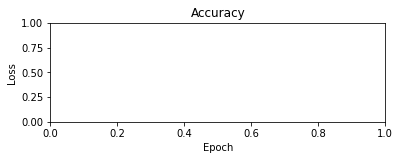

In [7]:
epochs = 3000
lr = [0.001,0.0002, 0.00001, 0.00005]
hyperparameter(epochs, lr, True)

Train Using Best Hyperparameter

In [ ]:
def train(model, lr, num_epochs, step_size=5000):
  plt.subplot(2, 1, 2, facecolor='white')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  loss_hist = []
  rec_freq = num_epochs//60
  
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.3, 0.79))
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/10, max_lr=lr, step_size_up=step_size, cycle_momentum=False, mode='triangular2')
  criterion = ModelLoss

  for epoch in range(num_epochs):
    for bx, data in enumerate(trn_dl):
      diff, amp = data
      diff, amp = diff.to(device), amp.to(device)
      loss = train_model(model, diff, amp, optimizer, criterion, scheduler)
      if((epoch+1) % 200 == 0):
        print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5))
      if((epoch+1) % rec_freq == 0):
          loss_hist.append(loss.item())
  plt.plot(loss_hist, '-', label= 'trn_acc:'+str(lr))
  plt.legend(loc='upper right')
  plt.gcf().set_size_inches(15, 15)
  plt.show()
  
  torch.save(model.state_dict(), 'amp1.pth')

Epoch:  200  Training Loss:  0.6879
Epoch:  400  Training Loss:  0.6871
Epoch:  600  Training Loss:  0.68618


KeyboardInterrupt: 

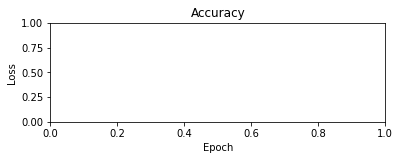

In [ ]:
PtychoModel = amp_Model.Model().to(device)
#PtychoModel.load_state_dict(torch.load('amp1.pth'))
train(PtychoModel, 0.0003, 10000)

Results

In [ ]:
def visualize(model):
  diff_grid = np.load('../dataset/compressed_diff_grid.npz')['arr_0']
  label = np.load('../dataset/norm_diffraction_label.npz')['arr_0']
  diff = torch.tensor(diff_grid,device=device).float()
  amp = torch.tensor(label[:, 1],device=device).float()
  model.eval()
  amp_pred = model(diff)
  
  f, ax = plt.subplots(2,4, figsize=(6, 12), facecolor='white')
  ax[0,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
  ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)

  ax[0,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
  ax[0,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((650,650)))
  ax[0,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((650,650)))
  ax[0,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((650,650)))
  ax[1,0].imshow(amp[0].cpu().detach().numpy().reshape((650,650)))
  ax[1,1].imshow(amp[1].cpu().detach().numpy().reshape((650,650)))
  ax[1,2].imshow(amp[2].cpu().detach().numpy().reshape((650,650)))
  ax[1,3].imshow(amp[3].cpu().detach().numpy().reshape((650,650)))


In [ ]:
PtychoModel = amp_Model.Model().to(device)
PtychoModel.load_state_dict(torch.load('amp1.pth'))
visualize(PtychoModel)

NameError: name 'amp_Model' is not defined